In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from numpy.linalg import norm


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
# Load the data
# file_path = "../SPY_section_3.csv"
file_path = "SPY_section_3.csv"
df = pd.read_csv(file_path)

In [32]:
# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [33]:
# Define LSTM model
class ComplexLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(ComplexLSTMModel, self).__init__()
        # Unidirectional LSTM for sequential stock price prediction
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)  # Removed bidirectional=True

        # Fully connected layers for added complexity
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 4, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        out = torch.relu(self.fc1(out))  # First fully connected layer
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))  # Second fully connected layer
        out = self.dropout2(out)
        out = self.fc3(out)  # Output layer (no activation for regression)
        return out


sequence_length = 10

# Reshape data into sequences
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)


In [34]:
# Define the target variable
if "Target" not in df.columns:
    # df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df["Target"] = df["Close"].shift(-1)
df = df.dropna()

In [35]:
# Adding SMA and EMA to the feature
short_term_period = 20
medium_term_period = 50
long_term_period = 200

# Compute the SMAs
df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean() # Short-term SMA
df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean() # Medium-term SMA
df['SMA_200'] = df['Close'].rolling(window=long_term_period).mean() # Long-term SMA

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Medium-term EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()  # Long-term EMA

df = df.dropna()

In [36]:
X = df.drop(columns=["Date", "Target"])
y = df["Target"]

feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200"]

train_size = int(X.shape[0] * 0.7)
val_size = int(X.shape[0] * 0.15)

scaler = MinMaxScaler()

# Split data into train, validation, and test
temp_train = X[:train_size]
temp_val = X[train_size:train_size + val_size]
temp_test = X[train_size + val_size:]

temp_train = temp_train[feature_columns]
temp_val = temp_val[feature_columns]
temp_test = temp_test[feature_columns]

# Fit and transform for train, transform for validation and test
temp_train = scaler.fit_transform(temp_train)
temp_val = scaler.transform(temp_val)
temp_test = scaler.transform(temp_test)

# Convert NumPy arrays back to DataFrames
temp_train = pd.DataFrame(temp_train, columns=feature_columns)
temp_val = pd.DataFrame(temp_val, columns=feature_columns)
temp_test = pd.DataFrame(temp_test, columns=feature_columns)

# Concatenate the data
X_scaled = pd.concat([temp_train, temp_val, temp_test], axis=0)

X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)

# Split sequentially
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

# Print sizes to confirm
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(X_scaled.shape)

Train: 1768, Val: 379, Test: 370
(2527, 11)


In [37]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


<span style="color: yellow; font-size: 40px;">Evaluating original LSTM</span>

In [38]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.0005
num_epochs = 500
patience = 30


===== Evaluation Results =====
Test Loss: 1275.9279
Test MAE: 30.6079
Average Error Percentage: 10.94%
Largest Error Percentage: 23.87%


<ipython-input-39-9a911407ca57>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  LSTM_model.load_state_dict(torch.load(LSTM_model_path, map_location=torch.device('cpu')))
/u

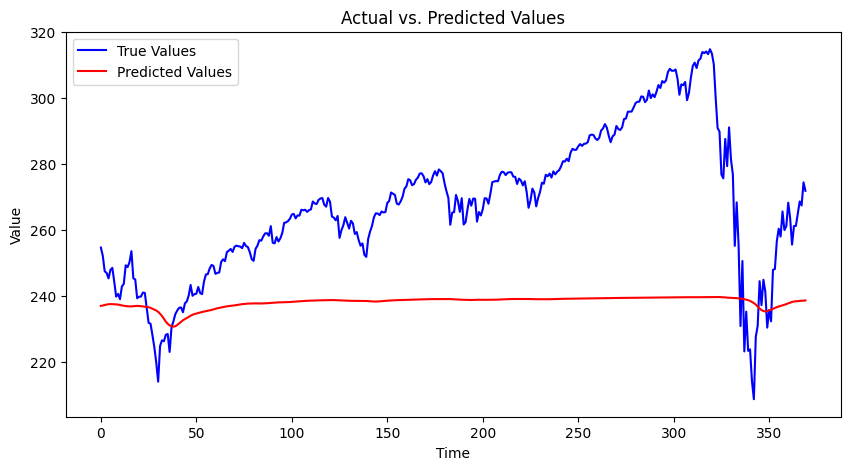

In [39]:
# Define paths
# LSTM_model_path = "../lstm_codes/lstm_models/lstm_section_3.pth"
LSTM_model_path = "lstm_section_3.pth"

# Load the trained model
LSTM_model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate).to(device)
LSTM_model.load_state_dict(torch.load(LSTM_model_path, map_location=torch.device('cpu')))
LSTM_model.eval()

# Define loss function
criterion = torch.nn.MSELoss()

# Evaluate on test data
test_loss = 0.0
test_mae = 0.0
all_true = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = LSTM_model(X_batch)
        loss = criterion(outputs, y_batch)
        mae = torch.mean(torch.abs(outputs - y_batch))

        test_loss += loss.item() * X_batch.size(0)
        test_mae += mae.item() * X_batch.size(0)

        all_true.extend(y_batch.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

# Compute final metrics
test_loss /= len(test_loader.dataset)
test_mae /= len(test_loader.dataset)

# Compute error percentages
all_true = np.array(all_true).flatten()
all_preds = np.array(all_preds).flatten()
error = np.abs(all_true - all_preds) / (np.abs(all_true) + 1e-8)
avg_error = np.mean(error) * 100
largest_error = np.max(error) * 100

# Print results
print("\n===== Evaluation Results =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Average Error Percentage: {avg_error:.2f}%")
print(f"Largest Error Percentage: {largest_error:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(all_true, label='True Values', color='blue')
plt.plot(all_preds, label='Predicted Values', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()


<span style="color: yellow; font-size: 40px;">Evaluating original autoencoder</span>

In [40]:
X_train = X_scaled[:train_size]
X_val = X_scaled[train_size:train_size + val_size]
X_test = X_scaled[train_size + val_size:]

In [41]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [42]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
test_dataset = TensorDataset(X_test_tensor, X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [43]:
input_dim = X_train.shape[1]

# Hyperparameters
encoding_dim = 5
learning_rate = 0.0005
dropout_rate = 0.3
epochs = 750
batch_size = 16
patience = 40

In [44]:
# autoencoder_model_path = "../autoencoder_codes/autoencoder_models/autoencoder_section_3.pth"
autoencoder_model_path = "autoencoder_section_3.pth"
autoencoder_model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim, dropout_rate=dropout_rate).to(device)
autoencoder_model.load_state_dict(torch.load(autoencoder_model_path, map_location=torch.device('cpu')))

<ipython-input-44-ef59dfc8bb4c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder_model.load_state_dict(torch.load(autoencoder_model_path, map_location=torch.devi

<All keys matched successfully>

In [45]:
autoencoder_model.eval()
with torch.no_grad():
    reconstructed_test = autoencoder_model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()
mse = np.mean((X_test - reconstructed_test) ** 2)
mae = np.mean(np.abs(X_test - reconstructed_test))
ree = np.mean(np.linalg.norm(X_test - reconstructed_test, axis=1) / np.linalg.norm(X_test, axis=1))
euclidean_dist = np.mean([norm(X_test[i] - reconstructed_test[i]) for i in range(len(X_test))])
reconstruction_error_percentage = (
    np.mean(np.abs(X_test - reconstructed_test) / (np.abs(X_test) + 1e-8), axis=1) * 100
)
average_error = np.mean(reconstruction_error_percentage)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, REE: {ree:.4f}, Euclidean Distance: {euclidean_dist:.4f}, Average Error: {average_error:.4f}%')

MSE: 0.0052, MAE: 0.0563, REE: 0.0482, Euclidean Distance: 0.2232, Average Error: 38.4449%


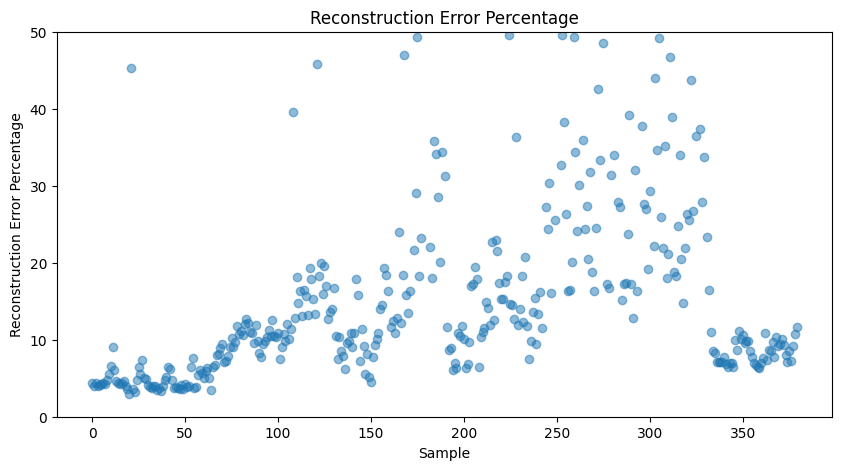

In [46]:
# Scatter plot of reconstruction error percentage
plt.figure(figsize=(10, 5))
plt.scatter(range(len(reconstruction_error_percentage)), reconstruction_error_percentage, alpha=0.5)
plt.ylim(0, 50)
plt.xlabel('Sample')
plt.ylabel('Reconstruction Error Percentage')
plt.title('Reconstruction Error Percentage')
plt.show()


<span style="color: yellow; font-size: 40px;">Bias correction model - single input</span>

In [47]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BiasPredictor(nn.Module):
#     def __init__(self, input_size, hidden_size1, dropout_rate):
#         super(BiasPredictor, self).__init__()

#         hidden_size2 = hidden_size1 // 2
#         hidden_size3 = hidden_size2 // 2
#         hidden_size4 = hidden_size3 // 2  # New additional layer

#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.dropout1 = nn.Dropout(dropout_rate)

#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.dropout2 = nn.Dropout(dropout_rate)

#         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
#         self.dropout3 = nn.Dropout(dropout_rate)

#         self.fc4 = nn.Linear(hidden_size3, hidden_size4)  # New additional layer
#         self.dropout4 = nn.Dropout(dropout_rate)

#         self.fc5 = nn.Linear(hidden_size4, 1)  # Final output layer

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)

#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)

#         x = F.relu(self.fc3(x))
#         x = self.dropout3(x)

#         x = F.relu(self.fc4(x))  # New layer
#         x = self.dropout4(x)

#         return self.fc5(x)



import torch
import torch.nn as nn
import torch.nn.functional as F

class BiasPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(BiasPredictor, self).__init__()

        hidden_size2 = hidden_size // 2

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        return self.fc3(x)

In [48]:
# Get LSTM predictions of entire dataset
with torch.no_grad():
    X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
    LSTM_preds = LSTM_model(X_tensor).cpu().numpy()

# Put LSTM predictions into a new DataFrame
new_df = pd.DataFrame(LSTM_preds, columns=["LSTM_Pred"])


In [49]:
# Drop the first sequence_length rows
temp_y = y
temp_y = temp_y[sequence_length:]

# add the target variable to the new DataFrame
new_df["Target"] = temp_y.values

In [50]:
# Get reconstruction error percentage for the entire dataset
autoencoder_model.eval()
with torch.no_grad():
    reconstructed = autoencoder_model(torch.tensor(X_scaled.values, dtype=torch.float32).to(device)).cpu().numpy()

# Compute the MAE
reconstruction_error = np.mean(np.abs(X_scaled.values - reconstructed), axis=1)

# Compute the reconstruction error percentage
# reconstruction_error = np.mean(np.abs(X_scaled.values - reconstructed) / (np.abs(X_scaled.values) + 1e-8), axis=1) * 100
# reconstruction_error = np.mean((X_scaled.values - reconstructed) / ((X_scaled.values) + 1e-8), axis=1) * 100

# Drop the first sequence_length rows
reconstruction_error_new = reconstruction_error[sequence_length:]

# Add the reconstruction error to the new DataFrame
new_df["Reconstruction_error_single"] = reconstruction_error_new

# Get reconstruction error arr of past 10 days
reconstruction_error_arr = []
for i in range(sequence_length, len(reconstruction_error)):
    reconstruction_error_arr.append(reconstruction_error[i - sequence_length:i])


# Add the reconstruction error array to the new DataFrame
new_df["Reconstruction_error_arr"] = reconstruction_error_arr



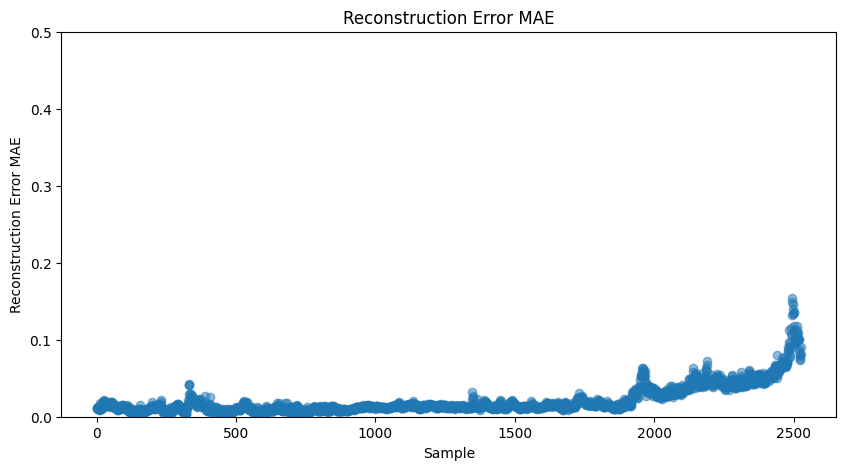

In [51]:
# plot reconstruction error scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(range(len(reconstruction_error)), reconstruction_error, alpha=0.5)
plt.ylim(0, 0.5)
plt.xlabel('Sample')
# plt.ylabel('Reconstruction Error Percentage')
# plt.title('Reconstruction Error Percentage')
plt.ylabel('Reconstruction Error MAE')
plt.title('Reconstruction Error MAE')
plt.show()


In [52]:
reconstruction_error_arr[0]

array([0.01112294, 0.01061798, 0.01121775, 0.01175785, 0.01235988,
       0.01201897, 0.01181609, 0.00948298, 0.00851219, 0.0115408 ])

In [53]:
# Calculate the difference between the target and LSTM prediction
new_df["Bias"] = new_df["Target"] - new_df["LSTM_Pred"]

In [54]:
y = new_df["Bias"]
X = new_df["Reconstruction_error_single"]
# X = new_df["Reconstruction_error_arr"]

In [55]:
# Sequential split
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train_raw = X[:train_size]
y_train_raw = y[:train_size]
X_val_raw = X[train_size:train_size + val_size]
y_val_raw = y[train_size:train_size + val_size]
X_test_raw = X[train_size + val_size:]
y_test_raw = y[train_size + val_size:]

# Scale using StandardScaler (fit only on train data)
# X_scaler = StandardScaler()
X_scaler = RobustScaler()
X_train_scaled = X_scaler.fit_transform(X_train_raw.values.reshape(-1, 1))
X_val_scaled = X_scaler.transform(X_val_raw.values.reshape(-1, 1))
X_test_scaled = X_scaler.transform(X_test_raw.values.reshape(-1, 1))

# y_scaler = StandardScaler()
y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw.values.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val_raw.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test_raw.values.reshape(-1, 1))

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)

# Print sizes
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 1761, Val: 377, Test: 379


In [56]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from torch.utils.data import DataLoader, TensorDataset

# Directory to save the models
save_dir = "uni_input_trials"
os.makedirs(save_dir, exist_ok=True)

# Number of trials
num_trials = 10

# Training parameters
input_size = 1
hidden_size = 16
dropout_rate = 0.02
learning_rate = 0.0001
num_epochs = 500
patience = 20

bias_model = BiasPredictor(input_size=input_size, hidden_size=hidden_size, dropout_rate=dropout_rate).to(device)

#load model
# bias_model.load_state_dict(torch.load("./models/bias_model_uni_input.pth"))
bias_model.load_state_dict(torch.load("bias_model_uni_input_section_3.pth", map_location=torch.device('cpu')))

bias_model.eval()

with torch.no_grad():
    combined_X = torch.cat((X_train, X_val, X_test), dim=0).to(device)
    y_pred = bias_model(combined_X).cpu().numpy()

outputs_unscaled = y_scaler.inverse_transform(y_pred.reshape(y_pred.shape[0], -1))


# # To store predictions for each trial
# all_predictions = {}

# for trial in range(num_trials):
#     print(f"Starting trial {trial + 1}/{num_trials}")

#     # Initialize model, loss function, and optimizer
#     bias_model = BiasPredictor(input_size=input_size, hidden_size=hidden_size, dropout_rate=dropout_rate).to(device)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(bias_model.parameters(), lr=learning_rate)

#     best_val_loss = np.inf
#     best_epoch = 0
#     best_model_state = None  # Store best model state

#     # Training loop
#     for epoch in range(num_epochs):
#         bias_model.train()
#         train_loss = 0.0
#         for X_batch, y_batch in train_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             optimizer.zero_grad()
#             outputs = bias_model(X_batch)
#             loss = criterion(outputs, y_batch)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * X_batch.size(0)

#         train_loss /= len(train_loader.dataset)

#         # Validation loop
#         bias_model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for X_batch, y_batch in val_loader:
#                 X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#                 outputs = bias_model(X_batch)
#                 loss = criterion(outputs, y_batch)
#                 val_loss += loss.item() * X_batch.size(0)

#         val_loss /= len(val_loader.dataset)

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_epoch = epoch
#             best_model_state = bias_model.state_dict()  # Save the best model state

#         elif epoch - best_epoch >= patience:
#             print(f"Trial {trial + 1}: Stopping early at epoch {epoch}")
#             break

#         print(f"Trial {trial + 1}, Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

#     # Save the best model from this trial
#     if best_model_state is not None:
#         model_filename = os.path.join(save_dir, f"bias_model_trial_{trial + 1}.pth")
#         torch.save(best_model_state, model_filename)
#         print(f"Saved model for Trial {trial + 1} to {model_filename}")

#         # Load best model and generate predictions
#         bias_model.load_state_dict(best_model_state)
#         bias_model.eval()

#         with torch.no_grad():
#             combined_X = torch.cat((X_train, X_val, X_test), dim=0).to(device)
#             y_pred = bias_model(combined_X).cpu().numpy()

#         outputs_unscaled = y_scaler.inverse_transform(y_pred.reshape(y_pred.shape[0], -1))

#         # Store predictions for this trial
#         all_predictions[f"trial_{trial + 1}"] = outputs_unscaled

# print("Completed all trials and saved models & predictions!")





<ipython-input-56-0f5dfa8363d0>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bias_model.load_state_dict(torch.load("bias_model_uni_input_section_3.pth", map_location=to

In [57]:
# concat y values of train test and val
combined_y = torch.cat((y_train, y_val, y_test), dim=0)
combined_y = combined_y.cpu().numpy()

In [58]:
# Create empty DataFrame
temp_df = pd.DataFrame()

temp_df["bias_model_uni_prediction"] = outputs_unscaled.flatten()


In [59]:
temp_df["LSTM_prediction_original"] = new_df["LSTM_Pred"]
temp_df["Target"] = new_df["Target"]
temp_df["New_predictions_uni"] = new_df["LSTM_Pred"] + temp_df["bias_model_uni_prediction"]


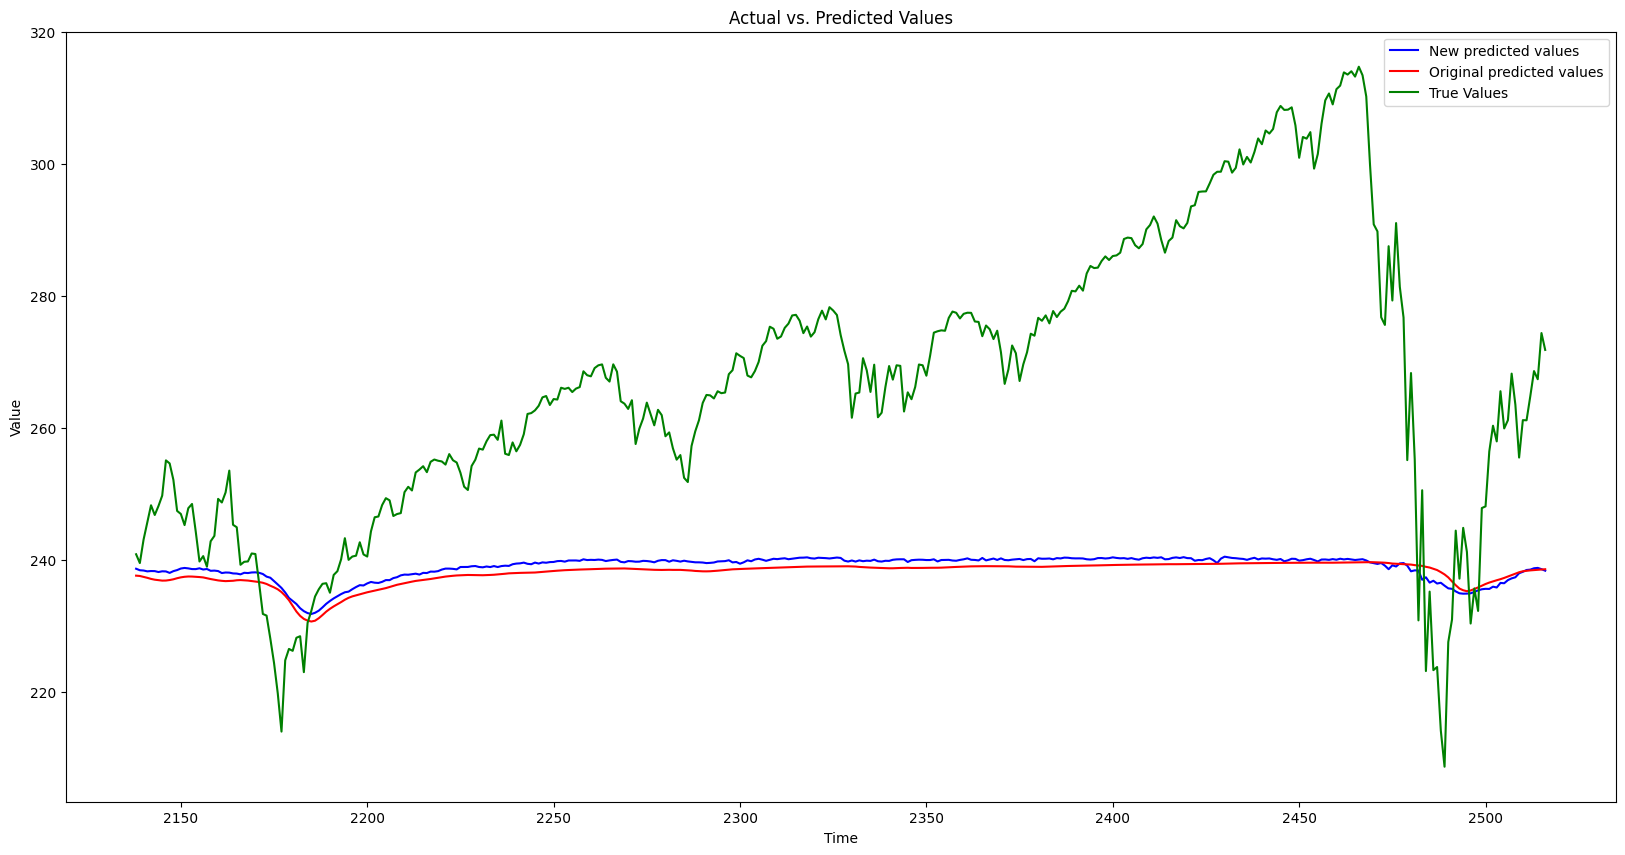

In [60]:
# plot graph of lstm prediction vs new predictions
plt.figure(figsize=(20, 10))
plt.plot(temp_df["New_predictions_uni"].iloc[train_size+val_size:], label='New predicted values', color='blue')
plt.plot(temp_df["LSTM_prediction_original"].iloc[train_size+val_size:], label='Original predicted values', color='red')
plt.plot(temp_df["Target"].iloc[train_size+val_size:], label='True Values', color='green')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()


In [61]:
original_LSTM_error_percent = np.mean(np.abs(temp_df["Target"].iloc[train_size+val_size:].values - temp_df["LSTM_prediction_original"].iloc[train_size+val_size:].values) / (np.abs(temp_df["Target"].iloc[train_size+val_size:].values) + 1e-8)) * 100
new_LSTM_error_percent = np.mean(np.abs(temp_df["Target"].iloc[train_size+val_size:].values - temp_df["New_predictions_uni"].iloc[train_size+val_size:].values) / (np.abs(temp_df["Target"].iloc[train_size+val_size:].values) + 1e-8)) * 100

print(f"Original LSTM Error Percentage: {original_LSTM_error_percent:.4f}%")
print(f"New LSTM Error Percentage: {new_LSTM_error_percent:.4f}%")

Original LSTM Error Percentage: 10.7707%
New LSTM Error Percentage: 10.4422%


<span style="color: yellow; font-size: 40px;">Bias correction model - multi input</span>

In [62]:
temp_df

,bias_model_uni_prediction,LSTM_prediction_original,Target,New_predictions_uni
0,2.592186,87.154678,92.040123,89.746864
1,2.373615,87.266373,89.875847,89.639984
2,2.701497,87.720543,89.340523,90.422043
3,2.434639,86.771088,86.373199,89.205727
4,2.107977,85.992126,85.088394,88.100105
...,...,...,...,...
2512,0.115510,238.381958,264.779175,238.497467
2513,0.276058,238.427246,268.596954,238.703308
2514,0.290496,238.467728,267.361877,238.758224
2515,0.053515,238.517700,274.360992,238.571213


In [63]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=["Reconstruction_error"])
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=["Reconstruction_error"])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=["Reconstruction_error"])

combined_X_df = pd.concat([X_train_scaled_df, X_val_scaled_df, X_test_scaled_df], axis=0)
combined_X_df

,Reconstruction_error
0,-0.448679
1,-0.049614
2,-0.595225
3,-0.164392
4,1.139530
...,...
374,13.805368
375,12.783048
376,12.691114
377,14.200126


In [64]:
combined_X_df['Reconstruction_error_array'] = np.nan

# Fill the new column with arrays of the past 10 reconstruction errors
# for i in range(len(combined_X_df)):
#     if i >= 9:
#         combined_X_df.at[i, 'reconstruction_error_array'] = combined_X_df['Reconstruction_error'][i-9:i+1].tolist()

reconstruction_error_arrays = []
for i in range(len(combined_X_df)):
    if i >= 9:
        reconstruction_error_arrays.append(combined_X_df['Reconstruction_error'][i-9:i+1].tolist())
    else:
        reconstruction_error_arrays.append(np.nan)  # Keep NaN for the first 9 rows

combined_X_df['Reconstruction_error_array'] = reconstruction_error_arrays



In [65]:
combined_X_df = combined_X_df.dropna()
combined_X_df = combined_X_df.reset_index(drop=True)
combined_X_df.head()

,Reconstruction_error,Reconstruction_error_array
0,-0.282491,"[-0.4486790804171111, -0.04961387123049615, -0..."
1,0.168114,"[-0.04961387123049615, -0.5952251877112481, -0..."
2,0.361517,"[-0.5952251877112481, -0.16439211868911244, 1...."
3,0.400292,"[-0.16439211868911244, 1.1395299216401547, 0.8..."
4,0.697508,"[1.1395299216401547, 0.8058615228831958, -0.25..."


In [66]:
if temp_df.shape[0] != combined_X_df.shape[0]:
    temp_df = temp_df.iloc[sequence_length-1:]
    temp_df = temp_df.reset_index(drop=True)
    print("Shape mismatch, adjusted DataFrame")
    print("temp_df shape:", temp_df.shape)
    print("combined_X_df shape:", combined_X_df.shape)

Shape mismatch, adjusted DataFrame
temp_df shape: (2508, 4)
combined_X_df shape: (2508, 2)


In [67]:
y_train_scaled_df = pd.DataFrame(y_train_scaled, columns=["Bias"])
y_val_scaled_df = pd.DataFrame(y_val_scaled, columns=["Bias"])
y_test_scaled_df = pd.DataFrame(y_test_scaled, columns=["Bias"])

combined_y_df = pd.concat([y_train_scaled_df, y_val_scaled_df, y_test_scaled_df], axis=0)

# drop first 9 rows of y
if combined_y_df.shape[0] != combined_X_df.shape[0]:
    combined_y_df = combined_y_df.iloc[sequence_length-1:]
    combined_y_df = combined_y_df.reset_index(drop=True)
    print("Shape mismatch, adjusted DataFrame")
    print("combined_y_df shape:", combined_y_df.shape)
    print("combined_X_df shape:", combined_X_df.shape)

Shape mismatch, adjusted DataFrame
combined_y_df shape: (2508, 1)
combined_X_df shape: (2508, 2)


In [68]:
X = combined_X_df["Reconstruction_error_array"]
y = combined_y_df['Bias']

# Sequential split
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train_raw = X[:train_size]
y_train_raw = y[:train_size]
X_val_raw = X[train_size:train_size + val_size]
y_val_raw = y[train_size:train_size + val_size]
X_test_raw = X[train_size + val_size:]
y_test_raw = y[train_size + val_size:]

# Convert data to PyTorch tensors
# X_train = torch.tensor(X_train_raw, dtype=torch.float32).unsqueeze(1)
# y_train = torch.tensor(y_train_raw, dtype=torch.float32).unsqueeze(1)
# X_val = torch.tensor(X_val_raw, dtype=torch.float32).unsqueeze(1)
# y_val = torch.tensor(y_val_raw, dtype=torch.float32).unsqueeze(1)
# X_test = torch.tensor(X_test_raw, dtype=torch.float32).unsqueeze(1)
# y_test = torch.tensor(y_test_raw, dtype=torch.float32).unsqueeze(1)
X_train = torch.tensor(np.stack(X_train_raw.values), dtype=torch.float32)
y_train = torch.tensor(y_train_raw.values, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(np.stack(X_val_raw.values), dtype=torch.float32)
y_val = torch.tensor(y_val_raw.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(np.stack(X_test_raw.values), dtype=torch.float32)
y_test = torch.tensor(y_test_raw.values, dtype=torch.float32).unsqueeze(1)

# Print sizes
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 1755, Val: 376, Test: 377


In [69]:
# Define bias predictor model
class BiasPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, use_bn):
        super(BiasPredictor, self).__init__()

        hidden_size2 = hidden_size // 2
        hidden_size3 = hidden_size2 // 2

        self.use_bn = use_bn

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size) if use_bn else nn.Identity()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2) if use_bn else nn.Identity()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3) if use_bn else nn.Identity()
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(hidden_size3, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        return self.fc4(x)


In [70]:
# Training function
def train_bias_predictor(model, train_loader, val_loader, num_epochs, patience, learning_rate):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = np.inf
    best_epoch = 0
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(num_epochs):
        ###### Training Phase ######
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)
        history["train_loss"].append(train_loss)

        ###### Validation Phase ######
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)
        history["val_loss"].append(val_loss)

        # Print Progress
        print(f"📉 Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model = model  # Store best model
        elif epoch - best_epoch >= patience:
            print(f"⏹️ Early stopping triggered at epoch {epoch+1}. Best epoch: {best_epoch+1}, Best Val Loss: {best_val_loss:.4f}")
            break

    return best_model, history


In [71]:
import itertools

# Create dataloader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # Hyperparameters
# input_size = 10
# hidden_size = 64
# dropout_rate = 0.2
# use_bn = True
# learning_rate = 0.0005
# num_epochs = 500
# patience = 20

# model = BiasPredictor(input_size=input_size, hidden_size=hidden_size, dropout_rate=dropout_rate, use_bn=use_bn).to(device)

# best_model, history = train_bias_predictor(model, train_loader, val_loader, num_epochs, patience, learning_rate)

# Define hyperparameter search space
param_grid = {
    "hidden_size": [16, 32, 64, 128],
    "dropout_rate": [0.0, 0.1, 0.2, 0.3],
    "use_bn": [True, False],
    "learning_rate": [0.001, 0.0005, 0.0001],
    "batch_size" : [8,16,32, 64]
}

# Number of runs per combination
num_repeats = 5

# Store results
results = []

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"

total_combinations = np.prod([len(v) for v in param_grid.values()])
count = 0
# Grid search loop
for params in itertools.product(*param_grid.values()):
    hidden_size, dropout_rate, use_bn, learning_rate, batch_size = params
    param_key = f"HS={hidden_size}, DR={dropout_rate}, BN={use_bn}, LR={learning_rate}, BS={batch_size}"

    print(f"\n🔍 Testing: {param_key}")
    print(f"{count} / {total_combinations} combinations\n")
    count += 1

    # Store metrics across runs
    avg_train_loss, avg_val_loss, avg_mae, avg_mse, avg_percent_error = 0, 0, 0, 0, 0

    for run in range(num_repeats):
        print(f"⚡ Run {run+1}/{num_repeats}")

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        model = BiasPredictor(input_size=10, hidden_size=hidden_size, dropout_rate=dropout_rate, use_bn=use_bn).to(device)

        # Train model
        best_model, history = train_bias_predictor(model, train_loader, val_loader, num_epochs=500, patience=20, learning_rate=learning_rate)

        # Evaluate performance
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            y_pred_arr = best_model(X_tensor).cpu().numpy()

        # Unscale predictions
        outputs_arr_unscaled = y_scaler.inverse_transform(y_pred_arr.reshape(y_pred_arr.shape[0], -1))

        # Store predictions
        temp_df["bias_model_arr_prediction"] = outputs_arr_unscaled.flatten()
        temp_df["New_predictions_arr"] = temp_df["LSTM_prediction_original"] + temp_df["bias_model_arr_prediction"]

        # Compute error metrics
        target_vals = temp_df["Target"].iloc[train_size+val_size:].values
        pred_vals = temp_df["New_predictions_arr"].iloc[train_size+val_size:].values

        mae = np.mean(np.abs(target_vals - pred_vals))
        mse = np.mean((target_vals - pred_vals) ** 2)
        percent_error = np.mean(np.abs(target_vals - pred_vals) / (np.abs(target_vals) + 1e-8)) * 100

        # Accumulate metrics
        avg_train_loss += history["train_loss"][-1] / num_repeats
        avg_val_loss += history["val_loss"][-1] / num_repeats
        avg_mae += mae / num_repeats
        avg_mse += mse / num_repeats
        avg_percent_error += percent_error / num_repeats

    # Store results
    results.append({
        "hidden_size": hidden_size,
        "dropout_rate": dropout_rate,
        "use_bn": use_bn,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "MAE": avg_mae,
        "MSE": avg_mse,
        "Percent Error": avg_percent_error
    })

# Convert results to DataFrame and sort by best validation loss
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Percent Error", ascending=True)

# Print best hyperparameters
best_params = results_df.iloc[0]
print("\n🏆 Best Hyperparameters Found:")
print(best_params)

# Save results to CSV
results_df.to_csv("grid_search_results.csv", index=False)





Streaming output truncated to the last 5000 lines.
📉 Epoch 1/500 - Train Loss: 0.6204, Val Loss: 12.2265
📉 Epoch 2/500 - Train Loss: 0.5864, Val Loss: 12.5081
📉 Epoch 3/500 - Train Loss: 0.5819, Val Loss: 12.5132
📉 Epoch 4/500 - Train Loss: 0.5739, Val Loss: 12.1447
📉 Epoch 5/500 - Train Loss: 0.5650, Val Loss: 18.5007
📉 Epoch 6/500 - Train Loss: 0.5578, Val Loss: 12.0413
📉 Epoch 7/500 - Train Loss: 0.5590, Val Loss: 11.2328
📉 Epoch 8/500 - Train Loss: 0.5515, Val Loss: 14.0446
📉 Epoch 9/500 - Train Loss: 0.5570, Val Loss: 13.4536
📉 Epoch 10/500 - Train Loss: 0.5528, Val Loss: 13.2056
📉 Epoch 11/500 - Train Loss: 0.5491, Val Loss: 12.7800
📉 Epoch 12/500 - Train Loss: 0.5457, Val Loss: 13.1263
📉 Epoch 13/500 - Train Loss: 0.5410, Val Loss: 13.1181
📉 Epoch 14/500 - Train Loss: 0.5382, Val Loss: 11.9005
📉 Epoch 15/500 - Train Loss: 0.5275, Val Loss: 13.1302
📉 Epoch 16/500 - Train Loss: 0.5190, Val Loss: 11.1635
📉 Epoch 17/500 - Train Loss: 0.5206, Val Loss: 13.4903
📉 Epoch 18/500 - Train 

In [72]:
print("Top 5 results")
results_df.head(5)

Top 5 results


,hidden_size,dropout_rate,use_bn,learning_rate,batch_size,train_loss,val_loss,MAE,MSE,Percent Error
95,16,0.3,False,0.0001,64,0.645557,9.930353,27.644496,1086.637253,9.930097
131,32,0.1,True,0.0001,64,0.671834,10.173335,27.682702,1086.851892,9.958742
178,32,0.3,True,0.0001,32,0.656007,10.110869,27.720755,1090.909312,9.960780
82,16,0.3,True,0.0001,32,0.674096,9.917180,27.801951,1099.836372,9.991868
75,16,0.3,True,0.0010,64,0.605918,10.273479,28.030686,1112.805783,10.067977


In [73]:
# # Create dataloader
# train_dataset = TensorDataset(X_train, y_train)
# val_dataset = TensorDataset(X_val, y_val)
# test_dataset = TensorDataset(X_test, y_test)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # Hyperparameters
# input_size = 10
# hidden_size = 64
# dropout_rate = 0.2
# use_bn = True
# learning_rate = 0.0005
# num_epochs = 500
# patience = 20

# model = BiasPredictor(input_size=input_size, hidden_size=hidden_size, dropout_rate=dropout_rate, use_bn=use_bn).to(device)

# best_model, history = train_bias_predictor(model, train_loader, val_loader, num_epochs, patience, learning_rate)


In [74]:
# best_model.eval()

# with torch.no_grad():
#     X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
#     y_pred_arr = best_model(X_tensor).cpu().numpy()

# outputs_arr_unscaled = y_scaler.inverse_transform(y_pred_arr.reshape(y_pred_arr.shape[0], -1))

# # Add predictions into df
# temp_df["bias_model_arr_prediction"] = outputs_arr_unscaled.flatten()
# temp_df['New_predictions_arr'] = temp_df["LSTM_prediction_original"] + temp_df["bias_model_arr_prediction"]

In [75]:
# # plot line graph of bias_model_arr_prediction vs original
# plt.figure(figsize=(20, 10))
# plt.plot(temp_df["New_predictions_arr"].iloc[train_size+val_size:], label='Array predictions', color='blue')
# plt.plot(temp_df["New_predictions_uni"].iloc[train_size+val_size:], label='Single input predictions', color='red')
# plt.plot(temp_df["Target"].iloc[train_size+val_size:], label='True Values', color='green')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Actual vs. Predicted Values')
# plt.legend()
# plt.show()

In [76]:

# # get prediction error percentages
# original_error_percent = np.mean(np.abs(temp_df["Target"].iloc[train_size+val_size:].values - temp_df["LSTM_prediction_original"].iloc[train_size+val_size:].values) / (np.abs(temp_df["Target"].iloc[train_size+val_size:].values) + 1e-8)) * 100
# uni_input_error_percent = np.mean(np.abs(temp_df["Target"].iloc[train_size+val_size:].values - temp_df["New_predictions_uni"].iloc[train_size+val_size:].values) / (np.abs(temp_df["Target"].iloc[train_size+val_size:].values) + 1e-8)) * 100
# arr_input_error_percent = np.mean(np.abs(temp_df["Target"].iloc[train_size+val_size:].values - temp_df["New_predictions_arr"].iloc[train_size+val_size:].values) / (np.abs(temp_df["Target"].iloc[train_size+val_size:].values) + 1e-8)) * 100

# print("Percentages over test set\n")
# print(f"Original LSTM Error Percentage: {original_error_percent:.4f}%")
# print(f"New LSTM Error Percentage (Single Input): {uni_input_error_percent:.4f}%")
# print(f"New LSTM Error Percentage (Array Input): {arr_input_error_percent:.4f}%")

In [77]:
# # plot graph over entire dataset
# plt.figure(figsize=(20, 10))
# plt.plot(temp_df["New_predictions_arr"], label='Array predictions', color='blue')
# plt.plot(temp_df["New_predictions_uni"], label='Single input predictions', color='red')
# plt.plot(temp_df["Target"], label='True Values', color='green')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Actual vs. Predicted Values')
# plt.legend()
# plt.show()

In [78]:
# # get prediction error percentages
# original_error_percent = np.mean(np.abs(temp_df["Target"].values - temp_df["LSTM_prediction_original"].values) / (np.abs(temp_df["Target"].values) + 1e-8)) * 100
# uni_input_error_percent = np.mean(np.abs(temp_df["Target"].values - temp_df["New_predictions_uni"].values) / (np.abs(temp_df["Target"].values) + 1e-8)) * 100
# arr_input_error_percent = np.mean(np.abs(temp_df["Target"].values - temp_df["New_predictions_arr"].values) / (np.abs(temp_df["Target"].values) + 1e-8)) * 100

# print("Percentages over entire set\n")
# print(f"Original LSTM Error Percentage: {original_error_percent:.4f}%")
# print(f"New LSTM Error Percentage (Single Input): {uni_input_error_percent:.4f}%")
# print(f"New LSTM Error Percentage (Array Input): {arr_input_error_percent:.4f}%")
